# Numerical Illustrations (Logisitic)


We will use a logistic model solved using logistic
 regression to illustrate the theoretical influence function bound proven in this paper. 

## Logisitic Design

We simulate a simple logistic model $y_i \sim \text{Binomial}(p_i)$, where  $p_i= \frac{1}{1+ \exp{(-(x_i^T\theta + \mu_i))}}$ for $n=[30, 1000]$. Each $x_i$ is iid standard normal random variables and $\theta_\star \in \mathbb{R}^9$ is fixed ahead of time. In order to introduce contaimination into the dataset, we let $\mu_i = (1-b_i)N(0,1)+b_iN(0,10)$ and $b_i\sim \text{Bernoulli}(.1)$.

We use a sample of $n = 50,000$ to simulate the population influence function.

### Notation
For our analysis we use the following notation:

$z=(x, y)$

$\sigma(x, \theta) = \frac{1}{1+\exp{(-x^T\theta)}}$

$\ell(z,\theta)= -y \log(\sigma(x, \theta)) + (1-y)\log(1-\sigma(x, \theta))$ is the loss function

$H_\star = \nabla_{\theta_\star}^2 \ell (\theta_\star)$ is the population Hessian

$H_n(\theta_n) := \frac{1}{n} \sum_{i=1}^n \nabla_{\theta_n}^2 \ell(z_i, \theta_n)$ is the estimate of the Hessian

$\theta_n$ is calculated using logistic regression


In [9]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from utils import run_sim_log, generate_theta_star, sim_contaminated_log

# Generate theta*
dim = 9
theta_star = generate_theta_star(dim)

# Empirical Influence Function for Logistic Regression

We will use the following closed form solution for the empirical influence function provided by Cook and Weisberg (1982).

$I_n(z)= -H_n(\theta_n)^{-1}\nabla \ell(z,\theta_n)$

We define the following:

$H_n(\theta_n) = \frac1n\sum_{i=1}^n  x_ix_i^T(\sigma(x_i,\theta_n)(1-\sigma(x_i,\theta_n)))$

$\nabla \ell(z,\theta_n) = x^T(\sigma(x,\theta_n) - y)$

$\theta_n$ is calculated using logistic regression

In [10]:
# Finding theta values using logistic regression
def logistic(x, y):
    clf = linear_model.LogisticRegression(penalty='none')
    clf.fit(x, y)
    return (clf)


def sigma(x, theta):
    return (1 / (1 + np.exp(-1 * (np.dot(x, np.transpose(theta))))))


def emp_H_func(x, theta):
    return (1 / x.shape[0]) * np.dot(np.dot(np.transpose(x), (np.diag(sigma(x, theta) * (1 - sigma(x, theta))))), x)


def grad_loss_func(x_con, y_con, theta):
    return ((np.dot(np.transpose(x_con), (sigma(x_con, theta) - y_con))))

# Empirical Influence Function for Logistic Regression
def emp_if_fn(x_sim, y_sim, x_con, y_con):
    ols_theta = logistic(x_sim, y_sim).coef_
    grad_loss = grad_loss_func(x_con, y_con, ols_theta[0])
    H = emp_H_func(x_sim, ols_theta[0])
    H_inv_x = np.linalg.solve(H, grad_loss)
    return (-1 * H_inv_x, H)


## Run Simulations
We now calculate the difference between the empirical influence and population influence of $100$ simulated contamination datapoint using different training data sample sizes ($n = 29, 60, 121, 245, 495, 1000$). We consider the population influence function to be the empriical influence calculated at $n=50,000$.

In [11]:
# Run simulation
eps = .1
n_ls = list(np.logspace(np.log10(30), np.log10(1000), 6).astype(int))
n_pop = 50000
n_sim = 100

x_pop, y_pop, mean_diff_abs_total, n_samp, sd_diff_abs_total = run_sim_log(
    dim, eps, n_pop, n_ls, n_sim, emp_if_fn, theta_star)


## Calculate Statistical Bound (Theorem 1)
We calculate the bound from Theorem 1 without coefficients using the following equations. 

$\|I_n(z) - I(z)\|_{H_\star}^2 \leq \frac{p_\star^2}{\mu_\star n} log(\frac p\delta)^3$

where, $p_\star = \text{Tr}\bigg [H_\star^{-1/2}G_\star H_\star^{-1/2} \bigg] = \text{Tr}\bigg [H_\star^{-1}G_\star\bigg ]$

In [12]:
def stat_bound(p_star, mu_star, n, delta, p):
    return ((p_star ** 2) / (mu_star * pd.DataFrame(n)) * np.log(p / delta) ** 3)


def p_star_func(H, x_con, y_con):
    H_inverse = np.linalg.inv(H)
    # Find G_\star, gradient of a single point
    grad = grad_loss_func(x_con, y_con, ols_theta[0])  # n
    G_star = np.average(np.dot(grad, np.transpose(grad)))  # 1
    return (np.trace(H_inverse * G_star))


# Gather variables
delta = .05
p = 9
rng = np.random.RandomState(1)
# Generate 100 contaminated points
x_con_ls, y_con_ls = sim_contaminated_log(p, n_sim, rng, theta_star)
# Get population theta and H
ols_theta = logistic(x_pop, y_pop).coef_
H_pop = emp_H_func(x_pop, ols_theta[0])

# Calculate bounds
mu_star = np.min(np.linalg.eig(H_pop)[0])
n = list(np.logspace(np.log10(30), np.log10(1000), 6).astype(int))[1:6]
stat_bound_ls = stat_bound(p, mu_star, n, delta, 9)


## Graph Results

In [13]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 18
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['lines.markersize'] = 12
shape = ["o", "X", "s", "^", "P"]
line = ["solid", "dotted", "dashed", "dashdot", "loosely dotted"]
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']


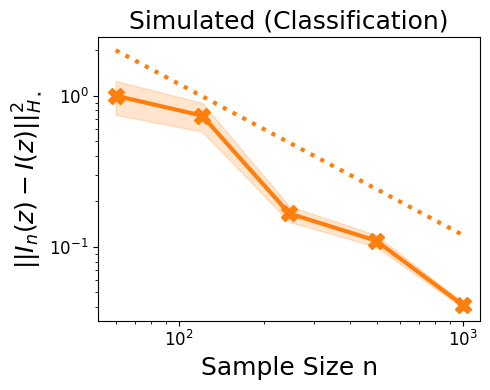

In [14]:
# Graph Results
import pandas as pd
bound_val_results = pd.DataFrame(
    {"mean_diff_abs": mean_diff_abs_total, "n": n_samp, "sd_diff_abs": sd_diff_abs_total})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
data = bound_val_results[1:6]
mean = np.abs(data['mean_diff_abs']) / np.max(np.abs(data['mean_diff_abs']))
sd = data['sd_diff_abs'] / np.max(np.abs(data['sd_diff_abs']))
ax.plot(np.abs(data['n']), mean, color=COLORS[1], marker=shape[1],
        linestyle=line[0], markersize=11, label="Empirical")
# Scale the statistical bound by a constant of 2
ax.plot(np.abs(data['n']), 2 * stat_bound_ls[0] / np.max(stat_bound_ls[0]),
        color=COLORS[1], linestyle=line[1], label="Bound")
ax.fill_between(np.abs(data['n']), mean - 1.96 * sd / np.sqrt(data['n']),
                mean + 1.96 * sd / np.sqrt(data['n']), alpha=0.2, color=COLORS[1])
ax.set_ylabel(r'$\|\| I_{n}(z) - I(z) \|\|_{H_\star}^2$')
ax.set_xlabel("Sample Size n")
ax.set_title('Simulated (Classification)')
ax.set_xscale("log")
ax.set_yscale("log")

plt.tight_layout()
